In [1]:
import numpy as np
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
# from pulp import *
from scipy import interpolate
from scipy.optimize import fmin, fminbound, minimize, BFGS, fmin_bfgs, differential_evolution
import math

In [2]:
class Vehicle:
    def __init__(self, ):
        self.pos=[] # x, y [m]
        self.size=[] # length, width [m]
        self.ori=[] # [rad]
        self.vel=[] # [m/s]

In [3]:
def vehicle_plot(pos, size, ori, ax=None):
    if 0:
        points = [
            [pos[0] - size[0]/2, pos[0] + size[0]/2, pos[0] + size[0]/2, pos[0] - size[0]/2, pos[0] - size[0]/2],
            [pos[1] - size[1]/2, pos[1] - size[1]/2, pos[1] + size[1]/2, pos[1] + size[1]/2, pos[1] - size[1]/2]
        ]
    else:
        points = [[],[]]
        x = [- size[0]/2, size[0]/2, size[0]/2, - size[0]/2, - size[0]/2]
        y = [- size[1]/2, - size[1]/2, size[1]/2, size[1]/2, - size[1]/2]
        A = [[np.cos(ori), -np.sin(ori)],[np.sin(ori), np.cos(ori)]]
        for i in range(len(x)):
            buf = np.dot(A,np.array([x[i],y[i]]))
            points[0].append(buf[0] + pos[0])
            points[1].append(buf[1] + pos[1])
    if ax == None:
        plt.plot(points[0], points[1])
    else:
        ax.plot(points[0], points[1])

In [4]:
road_length = 80

# 駐車車両
parked_vehicle = Vehicle()
parked_vehicle.pos = [road_length/2, 1.5]
#parked_vehicle.pos = [road_length/2, .5]
parked_vehicle.size = [4, 2]
parked_vehicle.ori = 0
parked_vehicle.ori = 0

# 自車
ego_vehicle = Vehicle()
ego_vehicle.pos = [0,0]
ego_vehicle.size = [4,2]
ego_vehicle.ori = 0
ego_vehicle.vel = 10/3.6

 # 車線
width_lane = 4
line_left = [[0,road_length],[width_lane/2, width_lane/2]]
line_center = [[0,road_length], [0,0]]
line_right = [[0,road_length],[-width_lane/2, -width_lane/2]]

Text(0, 0.5, 'Y[m]')

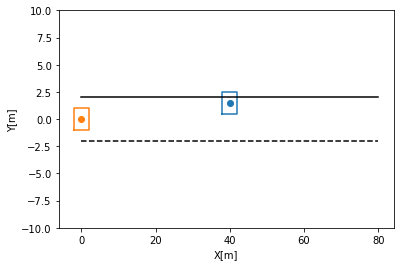

In [5]:
# 描画
plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

### Ref: https://qiita.com/Ken227/items/aee6c82ec6bab92e6abf

In [6]:
#interpld
# ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0
# 2点だとエラー
def spline1(x,y,point):
    kind_option = 'cubic' if len(x) > 3 else 'quadratic'
    f = interpolate.interp1d(x, y,kind=kind_option) #kindの値は一次ならslinear、二次ならquadraticといった感じに
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#Akima1DInterpolator
def spline2(x,y,point):
    f = interpolate.Akima1DInterpolator(x, y)
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#splprep
def spline3(x,y,point,deg):
    tck,u = interpolate.splprep([x,y],k=deg,s=0) 
    u = np.linspace(0,1,num=point,endpoint=True) 
    spline = interpolate.splev(u,tck)
    return spline[0],spline[1]

### Ref:https://myenigma.hatenablog.com/entry/2016/10/23/043111

In [7]:
# 点列から曲率計算
def CalcCurvature(x,y,npo=1):
    cv=[]

    ndata=len(x)

    for i in range(ndata):
        lind=i-npo
        hind=i+npo+1

        if lind<0:
            lind=0
        if hind>=ndata:
            hind=ndata
        #  print(lind,hind)

        xs=x[lind:hind]
        ys=y[lind:hind]
        #  print(xs,ys)
        (cxe,cye,re)=CircleFitting(xs,ys)
        #  print(re)

        if len(xs)>=3:
            # sign evalation 
            cind=int((len(xs)-1)/2.0)
            sign = (xs[0] - xs[cind]) * (ys[-1] - ys[cind]) - (ys[0] - ys[cind]) * (xs[-1] - xs[cind])

            # check straight line
            a = np.array([xs[0]-xs[cind],ys[0]-ys[cind]])
            b = np.array([xs[-1]-xs[cind],ys[-1]-ys[cind]])
            try:
                theta=math.degrees(math.acos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
                #  print(theta)
            except ValueError:
                print((np.linalg.norm(a)*np.linalg.norm(b)))
                print(np.dot(a,b))

            if theta==180.0:
                cv.append(0.0)#straight line
            elif sign>0:
                cv.append(1.0/-re)
            else:
                cv.append(1.0/re)
        else:
            cv.append(0.0)

    #  print(cv)
    return cv

# 円フィッティング
def CircleFitting(x,y):
    sumx  = sum(x)
    sumy  = sum(y)
    sumx2 = sum([ix ** 2 for ix in x])
    sumy2 = sum([iy ** 2 for iy in y])
    sumxy = sum([ix * iy for (ix,iy) in zip(x,y)])

    F = np.array([[sumx2,sumxy,sumx],
                  [sumxy,sumy2,sumy],
                  [sumx,sumy,len(x)]])

    G = np.array([[-sum([ix ** 3 + ix*iy **2 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 *iy + iy **3 for (ix,iy) in zip(x,y)])],
                  [-sum([ix ** 2 + iy **2 for (ix,iy) in zip(x,y)])]])

    try:
        T=np.linalg.inv(F).dot(G)
    except:
        return (0,0,float("inf"))

    cxe=float(T[0]/-2)
    cye=float(T[1]/-2)
    #  print (cxe,cye,T)
    try:
        re=math.sqrt(cxe**2+cye**2-T[2])
    except:
        return (cxe,cye,float("inf"))
    return (cxe,cye,re)

In [8]:
# 経路評価
def evaluation_path(X):
    # X = [x1, y1, xpre, xback]
    
    points = [
        [ego_vehicle.pos[0], parked_vehicle.pos[0] - X[2], parked_vehicle.pos[0] + X[0], parked_vehicle.pos[0] + X[3], line_center[0][1]], 
        [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + X[1], ego_vehicle.pos[1], line_center[1][1]]
    ]
    
    print("points : ", points)
    
    if ((X[0] + X[2]) > 0) & ((-X[0] + X[3]) > 0):
    
        if 0:
            path_coef = np.polyfit(points[0], points[1], 6)
            path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
            path_y = np.poly1d(path_coef)(path_x)
        else:
            path_x, path_y = spline2(points[0], points[1], 20)


        eval_val = 0 

        # (１)死角
        w_dead_area = 1
        eval_val += w_dead_area * calculation_dead_area(path_x, path_y, X[2])

        # (２)はみ出し
        w_out_of_road = 1
        eval_val += w_out_of_road * calculation_out_of_road(path_x, path_y)

        # (３)衝突
        w_collision = 1
        eval_val += w_collision * calculation_collision(path_x, path_y)

        # (４)道路中央を走行
        w_center_of_road = 1
        eval_val += w_center_of_road * calculation_center_of_road(path_x, path_y)

        # (５)ジャーク（yの二回微分）
        w_lat_jark = 1
        eval_val += w_lat_jark * calculation_lat_jark(path_x, path_y)    

        # (６)ハンドル角速度（曲率変化量） 
        w_steer_vel = 1
        eval_val += w_steer_vel * calculation_steer_vel(path_x, path_y)
    else:
        eval_val = 1e100
        
    return eval_val

# 制約(cons >= 0)
def cons_1(X):
    return (X[0] + X[2])

def cons_2(X):
    return (-X[0] + X[3])

In [9]:
# 死角の計算
def calculation_dead_area(path_x, path_y , pre):
    fr = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] - parked_vehicle.size[1]/2]
    fl = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] + parked_vehicle.size[1]/2]
    
    dead_area = 0
    pp = [0, 0]
    
    if 0:
        plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
        vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
        plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
        vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

        plt.plot(line_left[0], line_left[1], 'k')
        plt.plot(line_right[0], line_right[1], '--k')

        plt.ylim([-10,10])
        plt.xlim([0,line_center[0][1]])
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
    
    for i in range(len(path_x)):
        if 0:
            a = ( (fr[0] - path_x[i]) / (fr[1] - path_y[i]) ) * parked_vehicle.size[1]
            b = parked_vehicle.size[1] 
            dead_area += a * b * 1/2
        else:
            # if (path_x[i] < fr[0]) & (parked_vehicle.pos[0] - pre > path_x[i]):
            if (path_x[i] < fr[0]):
                a = (fr[1] - path_y[i]) / (fr[0] - path_x[i])
                b = fr[1] - a * fr[0]
                
                pp[0] = (fl[1] - b)/a
                pp[1] = fl[1]

                if (pp[0] > fl[0]):
                    dead_area += (pp[0] - fl[0])*(fl[1] - fr[1])*1/2
                # plt.plot([pp[0], fl[0], fr[0], pp[0]], [pp[1], fl[1], fr[1], pp[1]])
                
                if (path_y[i] > fr[1]):
                    dead_area += 1000
    
    return dead_area

In [10]:
# はみ出し
def calculation_out_of_road(path_x, path_y):
    return np.sum(path_y<line_right[1][0]) + 1000*np.sum(path_y>0)

In [11]:
# 衝突
def calculation_collision(path_x, path_y):
    d = np.sqrt((parked_vehicle.pos[0] - path_x) ** 2 + (parked_vehicle.pos[1] - path_y) ** 2)
    d_min = np.min(d)
    torelance = 5
    ret = np.sum(1/np.exp(d))
    if d_min < torelance:
        #ret = np.inf
        ret = 100000000*ret
        
    return ret

In [12]:
# 道路中央
def calculation_center_of_road(path_x, path_y):
    return np.sum(np.exp(np.abs(path_y - line_center[1][0])))

In [13]:
# 横ジャーク
def calculation_lat_jark(path_x, path_y):
    return np.sum(np.abs(np.diff(path_y, n=2)))

In [14]:
# ハンドル角速度
def calculation_steer_vel(path_x, path_y):
    cv = CalcCurvature(path_x, path_y)
    # plt.scatter(path_x, cv)
    return np.sum(np.abs(np.diff(cv, n=1)))

In [15]:
# dx, dy = fmin(evaluation_path, [0, 0])
# dx, dy = fminbound(evaluation_path, [-10, -3], [0, 0])

# X = [x1, y1, xpre, xback]
x_init = [0, 0, 2, 2]

dxmin = -20
dxmax = 0
dymin = -6
dymax = 0
premin = 5
premax = 20

bounds = [[dxmin,dxmax], [dymin,dymax], [premin,premax],  [premin,premax]]

constrains = (
    {'type': 'ineq', 'fun': cons_1},
    {'type': 'ineq', 'fun': cons_2}
)

res = differential_evolution(evaluation_path, bounds)            

points :  [[0, 29.78009182219224, 23.92097853354579, 50.46055271972051, 80], [0, 0, -3.9694193667634625, 0, 0]]
points :  [[0, 21.3202528177425, 34.58249137382889, 45.631608696719844, 80], [0, 0, -3.814079708072187, 0, 0]]
points :  [[0, 20.754615454058545, 39.285762163723334, 51.955623439405585, 80], [0, 0, -3.23234751127716, 0, 0]]
points :  [[0, 21.004351194957078, 38.400180699112525, 58.01911105645558, 80], [0, 0, -3.3043103035333488, 0, 0]]
points :  [[0, 23.241703801841744, 27.868162254550686, 45.93668132527345, 80], [0, 0, -0.38189613276134726, 0, 0]]
points :  [[0, 29.37468464978432, 20.424788007105256, 49.623981123082416, 80], [0, 0, -1.1314785719876346, 0, 0]]
points :  [[0, 30.262642288710953, 37.31885010498252, 55.531143078960746, 80], [0, 0, -3.4228443683991063, 0, 0]]
points :  [[0, 25.089182555951133, 33.691606114651925, 50.90435330758881, 80], [0, 0, -1.7740101014738792, 0, 0]]
points :  [[0, 26.03646705387258, 21.450497267040404, 51.52858491075257, 80], [0, 0, -1.96484

points :  [[0, 23.456097439089895, 22.183697383143745, 55.839623907124576, 80], [0, 0, -3.562195701485641, 0, 0]]
points :  [[0, 24.7154600347506, 38.72416702950032, 53.04997319162703, 80], [0, 0, -2.9422904268910806, 0, 0]]
points :  [[0, 32.54837982787393, 24.28409051673558, 53.6819151007168, 80], [0, 0, -3.5225932600705, 0, 0]]
points :  [[0, 34.14116369900178, 23.3417572732436, 58.43289591735479, 80], [0, 0, -2.4975979943390483, 0, 0]]
points :  [[0, 25.07114277114361, 26.56209074257705, 58.50351233447198, 80], [0, 0, 0.4397839261611243, 0, 0]]
points :  [[0, 25.084328191055036, 33.18669716209041, 58.81585887950858, 80], [0, 0, -0.2659508135430739, 0, 0]]
points :  [[0, 28.29102516162873, 32.00957514452744, 49.657491822826536, 80], [0, 0, 0.7156661580634571, 0, 0]]
points :  [[0, 31.149719304973893, 34.844072506865444, 59.17029558506201, 80], [0, 0, -0.6933877026207247, 0, 0]]
points :  [[0, 21.37046022005661, 36.75938250896181, 53.72541350712148, 80], [0, 0, -4.149241848190588, 0,

points :  [[0, 25.18692369997653, 37.173743917449976, 59.33912213468861, 80], [0, 0, -2.946393469414425, 0, 0]]
points :  [[0, 23.318743726989126, 39.5455777293776, 54.62643771468704, 80], [0, 0, -3.9718689825716558, 0, 0]]
points :  [[0, 21.350249427685252, 35.3123367177662, 58.307990328369854, 80], [0, 0, 0.8951078011781632, 0, 0]]
points :  [[0, 21.781261761608558, 36.25890025415944, 49.84204724536493, 80], [0, 0, -2.9961559041174715, 0, 0]]
points :  [[0, 24.866204596539454, 34.71552946515254, 45.97383524465057, 80], [0, 0, -3.571470726065005, 0, 0]]
points :  [[0, 20.914583654171444, 39.06133055520693, 55.12350725482509, 80], [0, 0, -0.4652205395614937, 0, 0]]
points :  [[0, 22.60917736027143, 38.7972055095393, 51.18803749225029, 80], [0, 0, -3.590588395576411, 0, 0]]
points :  [[0, 25.447641222457992, 36.56682084975816, 53.119580341489, 80], [0, 0, -3.5588729423905656, 0, 0]]
points :  [[0, 31.089013961630133, 34.98697220460162, 56.173225706256275, 80], [0, 0, -1.7179642728937066

points :  [[0, 24.28541935593237, 37.28350891993172, 58.039083265328074, 80], [0, 0, -3.9307145321211534, 0, 0]]
points :  [[0, 31.072716369009058, 36.64664996778622, 54.4832626073606, 80], [0, 0, -0.7709681295286268, 0, 0]]
points :  [[0, 22.37514556503387, 38.17303314912907, 50.32921328206413, 80], [0, 0, -3.030346358081915, 0, 0]]
points :  [[0, 22.37514556503387, 38.17303314912907, 48.447656629613796, 80], [0, 0, -3.030346358081915, 0, 0]]
points :  [[0, 23.82147104445738, 26.160474323944506, 45.29774966360282, 80], [0, 0, -2.758832499290407, 0, 0]]
points :  [[0, 28.238368754010484, 20.076671419965145, 59.258970749343334, 80], [0, 0, -2.4123469590105433, 0, 0]]
points :  [[0, 32.32554382905587, 26.036684847345388, 51.90555802019304, 80], [0, 0, -3.7680440531105237, 0, 0]]
points :  [[0, 22.8653152561688, 39.285762163723334, 51.955623439405585, 80], [0, 0, -3.3666495926750706, 0, 0]]
points :  [[0, 26.40151130926913, 30.70347578137918, 47.853323853099404, 80], [0, 0, -2.62191891191

points :  [[0, 21.422048220251334, 39.86913745523035, 59.05775854670975, 80], [0, 0, -4.051666138649876, 0, 0]]
points :  [[0, 26.607170077660236, 26.625929996073726, 56.86621092295812, 80], [0, 0, -1.4570241641691188, 0, 0]]
points :  [[0, 22.693385513959967, 30.630718611485918, 59.789650287733444, 80], [0, 0, -2.8887222235909613, 0, 0]]
points :  [[0, 21.37046022005661, 36.75938250896181, 58.60236313762108, 80], [0, 0, -3.374710905193572, 0, 0]]
points :  [[0, 33.20577166133456, 39.38520345441822, 57.75544424273669, 80], [0, 0, -3.3920978638076953, 0, 0]]
points :  [[0, 32.79710391682681, 37.28264177811045, 58.357160007842765, 80], [0, 0, -3.6231012024564286, 0, 0]]
points :  [[0, 20.630581850922464, 36.98225192589984, 53.10258489272752, 80], [0, 0, -3.820410168154, 0, 0]]
points :  [[0, 20.983600826207947, 37.75088958833811, 53.046318585466565, 80], [0, 0, -1.8945200831004394, 0, 0]]
points :  [[0, 33.63647141020605, 39.00912065222619, 45.73043370617775, 80], [0, 0, -3.8797822806004

points :  [[0, 33.96099571549723, 32.262197487452426, 54.373307001520914, 80], [0, 0, -3.596216260186968, 0, 0]]
points :  [[0, 23.54319323341589, 37.22520711790925, 55.14366549490382, 80], [0, 0, -3.987781739800388, 0, 0]]
points :  [[0, 24.340932702364515, 39.1118201041771, 51.308366186282235, 80], [0, 0, -2.9586779299419206, 0, 0]]
points :  [[0, 21.485164848730157, 37.9153842773762, 58.3421367517624, 80], [0, 0, -3.2623727127105138, 0, 0]]
points :  [[0, 21.8420074752647, 39.78960284332142, 48.17783473897212, 80], [0, 0, -3.048697229576904, 0, 0]]
points :  [[0, 30.025466304037803, 26.964082788891616, 59.67754148686521, 80], [0, 0, -2.3497872045246506, 0, 0]]
points :  [[0, 22.58636377455997, 38.46162767562398, 53.18797100581623, 80], [0, 0, -3.403437364505157, 0, 0]]
points :  [[0, 26.58890927455427, 36.919158958092765, 56.899812743739346, 80], [0, 0, -3.6972597780059484, 0, 0]]
points :  [[0, 29.366488336638728, 37.651250832887655, 47.35498088756942, 80], [0, 0, -2.53849262101317

points :  [[0, 31.959532956933728, 37.18036235528766, 59.7225712963903, 80], [0, 0, -3.2856346377259857, 0, 0]]
points :  [[0, 23.448682021879506, 29.148428785388127, 56.61231698594018, 80], [0, 0, -2.7794146369772337, 0, 0]]
points :  [[0, 31.401707878471825, 39.266740873104524, 54.581151208622025, 80], [0, 0, -3.204288166862856, 0, 0]]
points :  [[0, 30.89620970535752, 39.4196849193593, 50.158099745696546, 80], [0, 0, -2.643387529328704, 0, 0]]
points :  [[0, 22.470082603584956, 34.482366370220895, 56.7803360728452, 80], [0, 0, -3.450714857259274, 0, 0]]
points :  [[0, 21.840262159563416, 38.32332738339129, 46.35415206307708, 80], [0, 0, -3.395785503562884, 0, 0]]
points :  [[0, 27.464305347617167, 39.21958401357722, 55.36796098687111, 80], [0, 0, -3.6049360469167304, 0, 0]]
points :  [[0, 27.846683171250127, 39.3078286748055, 58.37292486958574, 80], [0, 0, -3.486607541450205, 0, 0]]
points :  [[0, 30.525027601696245, 37.42528235578767, 55.531143078960746, 80], [0, 0, -4.047853018605

points :  [[0, 33.96079471244989, 36.6393702159617, 57.46385074127764, 80], [0, 0, -3.0479579102686243, 0, 0]]
points :  [[0, 31.983500331532785, 39.178117936113495, 56.81194719619085, 80], [0, 0, -3.0474640802582167, 0, 0]]
points :  [[0, 21.02387166537337, 36.95680360221476, 51.82197833836102, 80], [0, 0, -4.149241848190588, 0, 0]]
points :  [[0, 33.20577166133456, 38.14305475527896, 59.098108788058944, 80], [0, 0, -2.9580355080345715, 0, 0]]
points :  [[0, 30.655599144402323, 39.42794057813069, 59.205991077141604, 80], [0, 0, -3.1708624779958896, 0, 0]]
points :  [[0, 20.664001955039804, 29.845777400992667, 55.52795477794215, 80], [0, 0, -3.8287315252042697, 0, 0]]
points :  [[0, 20.507063080955596, 33.773197969708065, 58.41980752935071, 80], [0, 0, -3.673577879410245, 0, 0]]
points :  [[0, 32.37501044919678, 38.967115995053575, 54.69695309650331, 80], [0, 0, -3.452051746454691, 0, 0]]
points :  [[0, 22.167550334142415, 32.73994604151876, 53.621494747987676, 80], [0, 0, -3.464042598

points :  [[0, 20.729010530453763, 35.21397149811206, 59.88884841357597, 80], [0, 0, -4.000376291378766, 0, 0]]
points :  [[0, 21.523292851960655, 39.7508420316302, 58.50394033391779, 80], [0, 0, -2.8297986364234173, 0, 0]]
points :  [[0, 33.273864028303535, 38.83037227822727, 59.61338268079026, 80], [0, 0, -3.0989298656106463, 0, 0]]
points :  [[0, 24.089266574172758, 38.23117045722662, 58.677783433355046, 80], [0, 0, -3.243970483573091, 0, 0]]
points :  [[0, 20.07511853348322, 38.163071586283124, 57.547570468667146, 80], [0, 0, -3.3500761750821333, 0, 0]]
points :  [[0, 21.100093547459064, 39.66787698933289, 51.58610431454258, 80], [0, 0, -3.710931793848225, 0, 0]]
points :  [[0, 34.59526624162952, 39.21958401357722, 56.48942942383153, 80], [0, 0, -2.9212698508179473, 0, 0]]
points :  [[0, 26.786183188039157, 29.88121133000607, 59.86740601017912, 80], [0, 0, -2.956460004741704, 0, 0]]
points :  [[0, 25.026474855870138, 35.57856152042942, 58.24683906955357, 80], [0, 0, -3.829674520330

points :  [[0, 22.630048525704236, 38.74269708658727, 56.4039461240673, 80], [0, 0, -3.485086485519555, 0, 0]]
points :  [[0, 25.189445905966235, 38.09818249767065, 54.773442346608704, 80], [0, 0, -3.9894303064738477, 0, 0]]
points :  [[0, 22.50941567656926, 38.74092635276822, 53.503889804089326, 80], [0, 0, -3.1202401666441153, 0, 0]]
points :  [[0, 29.44352363484534, 39.64989461261022, 59.869392266560254, 80], [0, 0, -2.7714550155402824, 0, 0]]
points :  [[0, 28.339370248555564, 38.98278043548676, 55.84745021003356, 80], [0, 0, -3.3060571356218844, 0, 0]]
points :  [[0, 27.212098191980786, 38.60506596485007, 59.93717523133162, 80], [0, 0, -3.6963234701753747, 0, 0]]
points :  [[0, 27.706586143805026, 38.41808334114147, 59.80512594680526, 80], [0, 0, -2.3047552363887966, 0, 0]]
points :  [[0, 22.30563835985204, 39.55537768641199, 50.627853757280036, 80], [0, 0, -3.357194575632654, 0, 0]]
points :  [[0, 22.190918590649716, 38.10297549151696, 56.23636223894504, 80], [0, 0, -3.3769081902

points :  [[0, 20.258341789501422, 31.452419996594745, 55.253792528197266, 80], [0, 0, -2.3062021567870685, 0, 0]]
points :  [[0, 20.00187412653388, 39.40337370427671, 57.525977531344715, 80], [0, 0, -2.869184702669431, 0, 0]]
points :  [[0, 25.67515801806608, 38.608113301656594, 52.7021721158106, 80], [0, 0, -3.202777846265165, 0, 0]]
points :  [[0, 25.87636843648913, 38.40373165234121, 52.01041220064101, 80], [0, 0, -2.7360774223911797, 0, 0]]
points :  [[0, 34.20753353295035, 38.81738428844213, 59.882528973950365, 80], [0, 0, -3.7297958265003306, 0, 0]]
points :  [[0, 20.020087262353805, 35.26576058870176, 47.8647571375036, 80], [0, 0, -3.718112038830088, 0, 0]]
points :  [[0, 27.30287928272157, 39.586604513035724, 52.405137987572246, 80], [0, 0, -3.485086485519555, 0, 0]]
points :  [[0, 20.57193376788635, 39.696960967992695, 58.46802853468809, 80], [0, 0, -3.261258935252176, 0, 0]]
points :  [[0, 32.58121326379516, 39.80198343553435, 49.7297146852612, 80], [0, 0, -3.025810975537490

points :  [[0, 33.70848574568111, 38.7504015048146, 48.00220424074111, 80], [0, 0, -2.90788479446654, 0, 0]]
points :  [[0, 20.264651828755056, 39.4732713463047, 49.36548403511956, 80], [0, 0, -3.3577494570661095, 0, 0]]
points :  [[0, 21.53215413651843, 39.54241761167434, 59.54882516094833, 80], [0, 0, -3.4662385916723215, 0, 0]]
points :  [[0, 20.567975060592058, 39.48385599974446, 59.26826160582357, 80], [0, 0, -3.415078232586559, 0, 0]]
points :  [[0, 20.767401121030304, 39.127087462781304, 53.90486228304663, 80], [0, 0, -3.09284136937823, 0, 0]]
points :  [[0, 21.406727030123932, 38.31084898024423, 59.64255572865197, 80], [0, 0, -3.6049360469167304, 0, 0]]
points :  [[0, 23.22925184828042, 38.656292151209925, 57.57731099888526, 80], [0, 0, -3.1115326491374553, 0, 0]]
points :  [[0, 21.210914267672802, 39.185521395641274, 57.6319201101135, 80], [0, 0, -3.397995736702258, 0, 0]]
points :  [[0, 20.01830744371825, 39.25666481434831, 59.58193346414994, 80], [0, 0, -3.098245706485601, 0

points :  [[0, 29.233718102728382, 39.664263469874925, 56.003651027749385, 80], [0, 0, -2.909042403930414, 0, 0]]
points :  [[0, 20.08761893308236, 39.38360554035211, 57.3169710158277, 80], [0, 0, -3.265666486987402, 0, 0]]
points :  [[0, 23.991662359996287, 39.58199612708075, 58.355203228859736, 80], [0, 0, -3.9894303064738477, 0, 0]]
points :  [[0, 22.168084440223424, 38.57413501574533, 57.640575511656166, 80], [0, 0, -3.8455413875457722, 0, 0]]
points :  [[0, 21.61907795097519, 39.08583641392513, 46.59041816625435, 80], [0, 0, -2.732188907973093, 0, 0]]
points :  [[0, 29.901069165837235, 38.83906295070422, 48.06172107791159, 80], [0, 0, -3.3996427605619175, 0, 0]]
points :  [[0, 26.204901143418006, 38.09462225130437, 46.774825836588064, 80], [0, 0, -2.709322671222962, 0, 0]]
points :  [[0, 23.253247584183903, 38.82309463849956, 52.88242782748111, 80], [0, 0, -3.192694301875914, 0, 0]]
points :  [[0, 30.731542754690327, 39.441288548334846, 51.157218434826504, 80], [0, 0, -3.060257218

points :  [[0, 24.08987315174018, 39.11774173640278, 58.327595598746235, 80], [0, 0, -3.207395562454587, 0, 0]]
points :  [[0, 21.69548680600367, 38.79144548982682, 58.9945325372577, 80], [0, 0, -3.5027325795401314, 0, 0]]
points :  [[0, 28.153678923516182, 37.886492902562516, 45.43649954149039, 80], [0, 0, -3.3305739188721635, 0, 0]]
points :  [[0, 21.27946444414396, 38.84760565823793, 52.26933757530729, 80], [0, 0, -3.474782725636212, 0, 0]]
points :  [[0, 20.137173058942306, 39.07574765298541, 59.76346234978031, 80], [0, 0, -3.3924058349898605, 0, 0]]
points :  [[0, 27.44528899372551, 39.7354748150078, 52.65559777064428, 80], [0, 0, -3.0632936043324417, 0, 0]]
points :  [[0, 27.778142703802978, 39.82800756485359, 54.49980752934697, 80], [0, 0, -3.379396897704087, 0, 0]]
points :  [[0, 21.2044157040378, 39.840539454152534, 57.94061928689555, 80], [0, 0, -3.1461735731599934, 0, 0]]
points :  [[0, 20.8662073219012, 39.493569235344204, 46.85402408833029, 80], [0, 0, -3.2632527430743785,

points :  [[0, 20.25133713814776, 39.31175244990371, 59.405519322130985, 80], [0, 0, -2.791092900730284, 0, 0]]
points :  [[0, 23.665331744334253, 39.734256706627605, 59.618052074826394, 80], [0, 0, -3.489720161579319, 0, 0]]
points :  [[0, 25.23736278517734, 38.608113301656594, 58.21561497935069, 80], [0, 0, -2.4612298091180644, 0, 0]]
points :  [[0, 20.751922862092727, 39.782099229656396, 59.389323552634266, 80], [0, 0, -3.2893391577009616, 0, 0]]
points :  [[0, 20.198136784981514, 39.551876758745635, 59.72728640511011, 80], [0, 0, -2.9937510904318287, 0, 0]]
points :  [[0, 20.020087262353805, 39.10195873473894, 58.41328815452331, 80], [0, 0, -2.8201957088328786, 0, 0]]
points :  [[0, 22.13232626867736, 39.69527025859722, 58.24096480166179, 80], [0, 0, -3.769987772150987, 0, 0]]
points :  [[0, 22.75086313343003, 38.705469489049406, 59.08369370743208, 80], [0, 0, -3.260128037191887, 0, 0]]
points :  [[0, 20.140175877057338, 39.210912276968855, 59.671521010233846, 80], [0, 0, -3.272402

points :  [[0, 20.227706447840525, 39.65174074702948, 49.230546165132225, 80], [0, 0, -2.8251870542413267, 0, 0]]
points :  [[0, 20.4383800720352, 39.69527025859722, 45.16474223651286, 80], [0, 0, -3.1534772700167943, 0, 0]]
points :  [[0, 20.204432448323317, 38.5083281707605, 58.83729966056938, 80], [0, 0, -3.1183610686138605, 0, 0]]
points :  [[0, 20.099549294805247, 39.56293271804764, 55.580726728799874, 80], [0, 0, -3.257859209471121, 0, 0]]
points :  [[0, 20.770501217748606, 33.897801022512574, 58.63506898261699, 80], [0, 0, -3.226444940648955, 0, 0]]
points :  [[0, 20.130012408292995, 33.04236624827691, 47.09343365517627, 80], [0, 0, -3.21081939104056, 0, 0]]
points :  [[0, 22.478292566452566, 39.33765919086835, 59.67754616378526, 80], [0, 0, -3.542639807740871, 0, 0]]
points :  [[0, 20.243221609686373, 36.230738983788335, 59.768787665724346, 80], [0, 0, -3.3769968229697582, 0, 0]]
points :  [[0, 20.652727905957107, 39.55650719828603, 59.4703372379891, 80], [0, 0, -3.234888356720

points :  [[0, 23.686408609672764, 39.664263469874925, 59.41350682890721, 80], [0, 0, -3.154042773175835, 0, 0]]
points :  [[0, 20.08761893308236, 28.13563227573941, 59.79271170410186, 80], [0, 0, -3.345474537781853, 0, 0]]
points :  [[0, 20.275384067414965, 39.84629205495646, 55.55917557739866, 80], [0, 0, -3.543712131309097, 0, 0]]
points :  [[0, 20.60376310167629, 39.56512607186499, 46.734536919245144, 80], [0, 0, -3.1731091103473146, 0, 0]]
points :  [[0, 20.3574024373627, 39.26967333430281, 59.70769496961991, 80], [0, 0, -3.29014429454444, 0, 0]]
points :  [[0, 28.09311987432754, 39.61937595564912, 46.62016360559154, 80], [0, 0, -2.990763090312077, 0, 0]]
points :  [[0, 20.60468800855582, 24.578237518961224, 57.62626874104412, 80], [0, 0, -3.3340729034333423, 0, 0]]
points :  [[0, 20.03653171790391, 39.653780157365794, 49.73764914254609, 80], [0, 0, -2.827697876756705, 0, 0]]
points :  [[0, 21.91220045695819, 26.7118245136391, 59.488838582587675, 80], [0, 0, -3.1018780435268942, 0

points :  [[0, 20.722946528100714, 39.65213483767124, 58.71570967156583, 80], [0, 0, -3.051066657391825, 0, 0]]
points :  [[0, 22.576733051403707, 39.78935077089613, 55.251068568992935, 80], [0, 0, -3.204288166862856, 0, 0]]
points :  [[0, 20.16838088708128, 39.64238954677818, 59.68499244706054, 80], [0, 0, -3.311934702307429, 0, 0]]
points :  [[0, 22.551694374042512, 39.84397216717204, 55.45448903049437, 80], [0, 0, -2.895411302046499, 0, 0]]
points :  [[0, 20.37462133380058, 24.016359816316175, 59.389323552634266, 80], [0, 0, -3.2893391577009616, 0, 0]]
points :  [[0, 22.01258697254169, 33.15271936656635, 56.2705971902286, 80], [0, 0, -3.263181696695904, 0, 0]]
points :  [[0, 20.288002090616338, 39.771217527068465, 59.59237190679431, 80], [0, 0, -3.412214451827043, 0, 0]]
points :  [[0, 27.013276343636264, 39.616558427857015, 46.454668186367726, 80], [0, 0, -3.233336607745734, 0, 0]]
points :  [[0, 20.115432430107383, 39.92690259426531, 59.08369370743208, 80], [0, 0, -3.2452798995819

points :  [[0, 20.327336244262753, 38.790384327031354, 51.28176325541273, 80], [0, 0, -3.1849570032625207, 0, 0]]
points :  [[0, 22.912037114003745, 39.51072941844032, 59.479970394916045, 80], [0, 0, -3.8303186996100234, 0, 0]]
points :  [[0, 20.804388774018125, 29.945091281432596, 59.8923338425833, 80], [0, 0, -3.284732189477234, 0, 0]]
points :  [[0, 27.60479644183113, 39.292266370034895, 53.27184027204824, 80], [0, 0, -3.927357689368872, 0, 0]]
points :  [[0, 20.37735969626429, 39.25072078408408, 57.68093169036467, 80], [0, 0, -3.3534440339529725, 0, 0]]
points :  [[0, 25.3453792522644, 39.06937773166247, 59.52114440835638, 80], [0, 0, -2.8341361797644407, 0, 0]]
points :  [[0, 34.18441111985674, 39.48237426514052, 58.97903752245516, 80], [0, 0, -3.406884827851939, 0, 0]]
points :  [[0, 20.031448914033096, 39.492876457842456, 58.09077670519768, 80], [0, 0, -3.4445695528057545, 0, 0]]
points :  [[0, 20.7827450772636, 38.98127499263733, 59.372698679247236, 80], [0, 0, -2.9431355271884

points :  [[0, 20.60468800855582, 39.78454201943569, 58.71448548614176, 80], [0, 0, -3.2852771979192017, 0, 0]]
points :  [[0, 20.22053881835676, 39.16143350692865, 59.80512594680526, 80], [0, 0, -3.1838980775542787, 0, 0]]
points :  [[0, 22.345447837254206, 39.73534023604816, 57.0633804506339, 80], [0, 0, -3.539547510754116, 0, 0]]
points :  [[0, 20.970424086101573, 23.05595558573383, 59.00218155266601, 80], [0, 0, -3.169651378118626, 0, 0]]
points :  [[0, 20.05975417982667, 26.67051767720946, 59.2073406196987, 80], [0, 0, -3.110530969444098, 0, 0]]
points :  [[0, 20.312084628939818, 20.063906354628305, 58.15152437984075, 80], [0, 0, -3.2111930161236923, 0, 0]]
points :  [[0, 20.147510462848075, 31.727449420889013, 59.066893793569214, 80], [0, 0, -3.1549272199348595, 0, 0]]
points :  [[0, 20.722946528100714, 39.57023655248082, 59.08303993664606, 80], [0, 0, -3.1751073127679783, 0, 0]]
points :  [[0, 22.66578566760576, 39.96805363067297, 59.758862291646494, 80], [0, 0, -3.0279554577833

points :  [[0, 20.04129444361946, 39.716070259683484, 52.276659610053144, 80], [0, 0, -3.9506261748731113, 0, 0]]
points :  [[0, 20.283295899741645, 38.07755885737467, 46.91114415300378, 80], [0, 0, -2.766762027068304, 0, 0]]
points :  [[0, 20.206089000069753, 33.12128985742257, 59.35546852976186, 80], [0, 0, -3.054406241093522, 0, 0]]
points :  [[0, 24.56770962049259, 39.831185244645866, 49.74394648787938, 80], [0, 0, -2.4252787592724956, 0, 0]]
points :  [[0, 20.85722357778384, 29.839224403493475, 45.811400963100766, 80], [0, 0, -3.295431106740149, 0, 0]]
points :  [[0, 20.737939572013026, 26.007906097142854, 58.79935207363913, 80], [0, 0, -3.2561225227714434, 0, 0]]
points :  [[0, 20.046872591609386, 26.519450482929184, 59.19111762111059, 80], [0, 0, -3.315334513147408, 0, 0]]
points :  [[0, 20.24051270938599, 39.93476117639274, 59.08369370743208, 80], [0, 0, -3.339580371432122, 0, 0]]
points :  [[0, 20.479227479190193, 39.75476717932392, 47.418970379906355, 80], [0, 0, -3.384789788

points :  [[0, 30.17349919938549, 39.97300985286694, 58.724488784638176, 80], [0, 0, -3.245279899581944, 0, 0]]
points :  [[0, 20.292945106379744, 39.82042332085524, 58.47556368997246, 80], [0, 0, -3.1701897316493257, 0, 0]]
points :  [[0, 21.599082251404006, 39.41612441386436, 58.83205788096507, 80], [0, 0, -3.3201567641558363, 0, 0]]
points :  [[0, 20.514628744441076, 38.99880666298805, 59.52034927929536, 80], [0, 0, -3.380589422689991, 0, 0]]
points :  [[0, 20.137173058942306, 23.11554143013351, 48.30219268402388, 80], [0, 0, -3.3677117895543383, 0, 0]]
points :  [[0, 20.139913049200484, 39.97336688235765, 59.988977300201896, 80], [0, 0, -3.0976889690100897, 0, 0]]
points :  [[0, 20.041921077628793, 39.66570566757689, 59.461366190287016, 80], [0, 0, -3.2641339507253484, 0, 0]]
points :  [[0, 20.48425859960819, 39.59385353564154, 59.90397302965491, 80], [0, 0, -3.5140238936565664, 0, 0]]
points :  [[0, 20.125836233128684, 39.567393612284455, 59.13602310199634, 80], [0, 0, -3.20897196

points :  [[0, 20.426462932996674, 39.14986611259219, 59.43321260869845, 80], [0, 0, -3.1177532882252326, 0, 0]]
points :  [[0, 20.600551924791507, 39.99173571541297, 58.943521166141664, 80], [0, 0, -3.1607089641189416, 0, 0]]
points :  [[0, 27.898406564593323, 39.91140386466601, 59.260495678623386, 80], [0, 0, -3.2792396065612532, 0, 0]]
points :  [[0, 32.33937505304799, 39.850149950282145, 47.94785754299351, 80], [0, 0, -2.8139898765573728, 0, 0]]
points :  [[0, 20.069722352030286, 39.974892577358716, 59.43380248078486, 80], [0, 0, -3.168964807172526, 0, 0]]
points :  [[0, 21.39000036840798, 39.15340744073105, 57.97096652582676, 80], [0, 0, -3.2679265909699016, 0, 0]]
points :  [[0, 20.226462861359792, 39.79521708358953, 58.58462346898297, 80], [0, 0, -3.1699922164745775, 0, 0]]
points :  [[0, 20.35957896927755, 39.973149059208005, 59.618103385093086, 80], [0, 0, -3.385698904402294, 0, 0]]
points :  [[0, 20.059083024851187, 38.553794758294785, 59.11217791840582, 80], [0, 0, -3.431320

points :  [[0, 20.021724322957546, 39.86640049047425, 59.64973533781583, 80], [0, 0, -3.2622816468009193, 0, 0]]
points :  [[0, 24.53110619638265, 39.88190718082927, 50.60700519391085, 80], [0, 0, -2.587785472422973, 0, 0]]
points :  [[0, 20.558496792701547, 39.885873812163055, 59.21848494805697, 80], [0, 0, -3.0294006947262284, 0, 0]]
points :  [[0, 20.013099334673434, 38.593126029444, 59.14747858923138, 80], [0, 0, -3.18042242618405, 0, 0]]
points :  [[0, 20.069621562662523, 39.99240192024379, 59.59608275644973, 80], [0, 0, -3.1155298674999514, 0, 0]]
points :  [[0, 20.02781764939245, 39.86463130328006, 50.30277527380501, 80], [0, 0, -3.2713727871764275, 0, 0]]
points :  [[0, 20.6397200637063, 39.96316821600715, 57.117831072724265, 80], [0, 0, -3.2599203406935935, 0, 0]]
points :  [[0, 20.220353640773936, 39.896697043709, 59.33279137607127, 80], [0, 0, -3.0827986536757077, 0, 0]]
points :  [[0, 20.08842136871854, 39.81864504509576, 59.4243122356455, 80], [0, 0, -3.129396187910462, 0,

points :  [[0, 20.137173058942306, 39.07574765298541, 59.172639789980295, 80], [0, 0, -3.2221133393406474, 0, 0]]
points :  [[0, 21.54665116971795, 39.92793989114459, 59.429550608004945, 80], [0, 0, -3.2607803805338627, 0, 0]]
points :  [[0, 20.07576088360634, 39.66570566757689, 59.461366190287016, 80], [0, 0, -3.045644970402309, 0, 0]]
points :  [[0, 20.69078305496932, 39.94133034622891, 59.807830999400394, 80], [0, 0, -3.14231811099728, 0, 0]]
points :  [[0, 20.71129470725404, 39.418281347304394, 59.83008874729951, 80], [0, 0, -3.3438022236104166, 0, 0]]
points :  [[0, 20.230676413377672, 39.191632034021104, 59.72786351057451, 80], [0, 0, -2.6367450456798256, 0, 0]]
points :  [[0, 20.02785398105972, 39.64532388338114, 58.93310089149373, 80], [0, 0, -3.245381628688687, 0, 0]]
points :  [[0, 20.211975356151818, 39.8881239462594, 59.657756294676794, 80], [0, 0, -3.17237097761304, 0, 0]]
points :  [[0, 20.058127302078837, 39.82570822672383, 59.65786407843417, 80], [0, 0, -3.1694690054320

points :  [[0, 31.16512641705557, 39.91928350268428, 59.10968402202211, 80], [0, 0, -3.3181265604008274, 0, 0]]
points :  [[0, 27.930331126867216, 26.22447432620048, 59.64116028977418, 80], [0, 0, -3.2442635435663227, 0, 0]]
points :  [[0, 20.08842718024418, 39.43805983377645, 59.84026626828909, 80], [0, 0, -3.1619005572639223, 0, 0]]
points :  [[0, 20.418025377415702, 39.886161828806166, 59.694750882567206, 80], [0, 0, -3.080866203168849, 0, 0]]
points :  [[0, 32.05319189490936, 39.218333897561365, 59.12281074355598, 80], [0, 0, -3.1498015117989535, 0, 0]]
points :  [[0, 20.110897369309956, 39.84366623260391, 59.263861260527484, 80], [0, 0, -2.9043742443029874, 0, 0]]
points :  [[0, 20.20160005830452, 39.80708137751631, 59.490248601013015, 80], [0, 0, -3.2622816468009193, 0, 0]]
points :  [[0, 20.00504505985582, 37.14640160049587, 59.065566807316884, 80], [0, 0, -3.161177664542393, 0, 0]]
points :  [[0, 20.20560096089545, 34.33738326494018, 59.53257955448973, 80], [0, 0, -3.1694259360

points :  [[0, 31.738388091418337, 39.782099229656396, 59.41715408323094, 80], [0, 0, -3.2213024583197356, 0, 0]]
points :  [[0, 34.104308154647505, 39.84870209340829, 59.521760031383074, 80], [0, 0, -3.1798149351039475, 0, 0]]
points :  [[0, 20.127267882829784, 39.81851112967117, 59.55293198466326, 80], [0, 0, -3.221986018642694, 0, 0]]
points :  [[0, 27.5938901819666, 32.58240636624351, 59.68584441339116, 80], [0, 0, -3.040226064938288, 0, 0]]
points :  [[0, 20.28457128083227, 39.689547835513395, 59.71215725299655, 80], [0, 0, -3.2048968555288795, 0, 0]]
points :  [[0, 20.245277502992348, 39.8553988908116, 59.74884305002966, 80], [0, 0, -3.055144545286728, 0, 0]]
points :  [[0, 20.00364426231448, 38.95550596311404, 59.828577625275294, 80], [0, 0, -3.1087566384722924, 0, 0]]
points :  [[0, 28.049311302654033, 39.77449181690643, 59.53305337713555, 80], [0, 0, -3.180223663323151, 0, 0]]
points :  [[0, 20.0067056012142, 39.97929155682724, 59.30148181140572, 80], [0, 0, -3.119967775563797

points :  [[0, 20.100096294596963, 39.90206156399826, 59.77998789596735, 80], [0, 0, -3.0810792663793602, 0, 0]]
points :  [[0, 20.084899273820607, 39.85256872719976, 59.65621030988582, 80], [0, 0, -3.1716433275283524, 0, 0]]
points :  [[0, 23.85233332490335, 39.7050235342721, 59.44054266008223, 80], [0, 0, -3.2305749926947502, 0, 0]]
points :  [[0, 24.552554030390013, 33.40751367602958, 59.45817982403332, 80], [0, 0, -3.1542889770567717, 0, 0]]
points :  [[0, 20.0273286937043, 39.89253760175129, 59.567964271587215, 80], [0, 0, -3.339752670103567, 0, 0]]
points :  [[0, 20.107403006183297, 39.79753043716765, 59.311575450046035, 80], [0, 0, -2.950747441714526, 0, 0]]
points :  [[0, 20.00945142161037, 39.951549954631865, 59.63570529529109, 80], [0, 0, -3.386425137138449, 0, 0]]
points :  [[0, 23.018023164541468, 26.939510266630123, 59.39143521820546, 80], [0, 0, -3.151266514938955, 0, 0]]
points :  [[0, 20.199629178544463, 39.92690259426531, 59.34347648930979, 80], [0, 0, -3.1583540344381

points :  [[0, 20.04630347593039, 39.935205298516415, 59.87907550646728, 80], [0, 0, -3.1375759170805457, 0, 0]]
points :  [[0, 21.502818020135724, 39.987228268467646, 59.36877938223475, 80], [0, 0, -3.1974020859609436, 0, 0]]
points :  [[0, 22.23963041462264, 39.859326328378586, 59.807830999400394, 80], [0, 0, -3.13531283183662, 0, 0]]
points :  [[0, 20.24486177896459, 39.68049546113452, 59.35289944942986, 80], [0, 0, -3.16651484917052, 0, 0]]
points :  [[0, 23.32888625881806, 39.902135567274286, 59.5766585651712, 80], [0, 0, -3.132447835536154, 0, 0]]
points :  [[0, 25.062588385811118, 39.98079826612359, 59.5529799328779, 80], [0, 0, -3.166885426143441, 0, 0]]
points :  [[0, 20.327336244262753, 39.94412131503087, 59.44749531511895, 80], [0, 0, -3.15902562612221, 0, 0]]
points :  [[0, 20.071735649131355, 39.66074486606272, 59.804014138992855, 80], [0, 0, -3.1039682543646396, 0, 0]]
points :  [[0, 20.075788922585726, 39.94333899789927, 59.52771126846861, 80], [0, 0, -3.1486590311461287

points :  [[0, 20.12998323739615, 39.96672273593906, 59.33430047773998, 80], [0, 0, -3.130602038479326, 0, 0]]
points :  [[0, 31.78404663931053, 30.348867774030403, 59.740886470701696, 80], [0, 0, -3.0963274758130144, 0, 0]]
points :  [[0, 21.459288103905454, 30.89801106224621, 58.97710940560297, 80], [0, 0, -3.109446578884521, 0, 0]]
points :  [[0, 20.09460861998409, 39.504712814726176, 59.79530693550154, 80], [0, 0, -2.928039114346223, 0, 0]]
points :  [[0, 20.082579069382007, 39.90695846666668, 59.81110719898922, 80], [0, 0, -3.0045794563824666, 0, 0]]
points :  [[0, 34.03307597636314, 35.01520728353721, 59.44102424709859, 80], [0, 0, -2.882261931523006, 0, 0]]
points :  [[0, 23.860653513048895, 31.036042665683112, 59.062202479642174, 80], [0, 0, -3.1126151632625163, 0, 0]]
points :  [[0, 20.138102920716378, 24.542404767859193, 59.21540692192548, 80], [0, 0, -3.1822113798607905, 0, 0]]
points :  [[0, 20.061368176532188, 21.91799532416325, 59.33266557768356, 80], [0, 0, -3.1681544925

points :  [[0, 20.1075331773925, 25.313343083349995, 59.361504284631295, 80], [0, 0, -3.1393874310752565, 0, 0]]
points :  [[0, 20.069587773472527, 39.97976356379427, 59.39311982639689, 80], [0, 0, -3.1486590311461287, 0, 0]]
points :  [[0, 20.046246135037553, 39.97339642890418, 59.63005240797247, 80], [0, 0, -3.118677468275166, 0, 0]]
points :  [[0, 20.06424972389156, 36.76481395095219, 59.1093726551651, 80], [0, 0, -3.1417214648560945, 0, 0]]
points :  [[0, 26.410172763924493, 30.916150413726722, 59.41667836126357, 80], [0, 0, -3.1021185477295, 0, 0]]
points :  [[0, 20.098364533999703, 39.884247938180685, 59.17739943845844, 80], [0, 0, -3.1665389858422346, 0, 0]]
points :  [[0, 20.0759950202764, 37.870061425123126, 59.56504360075709, 80], [0, 0, -3.0965923456506266, 0, 0]]
points :  [[0, 20.08745363224314, 33.759962699186005, 59.372698679247236, 80], [0, 0, -3.2517706602674457, 0, 0]]
points :  [[0, 34.45863518905933, 39.87980461904908, 59.36841134792623, 80], [0, 0, -3.0735270379278

points :  [[0, 20.14336879582549, 39.864984949993435, 59.63258372825403, 80], [0, 0, -3.1732317408006363, 0, 0]]
points :  [[0, 20.03750783159328, 39.948830875190495, 59.696447204506214, 80], [0, 0, -3.142703400275172, 0, 0]]
points :  [[0, 28.770954492536216, 22.333141191242028, 59.065566807316884, 80], [0, 0, -2.840245204159297, 0, 0]]
points :  [[0, 20.064291378485077, 28.71091262693055, 59.74509954428842, 80], [0, 0, -3.293212487232763, 0, 0]]
points :  [[0, 20.055931704922372, 29.964201566475822, 59.6518874497354, 80], [0, 0, -3.128454629514837, 0, 0]]
points :  [[0, 20.018475938828246, 39.99448615030402, 59.685429496357976, 80], [0, 0, -3.014227149516806, 0, 0]]
points :  [[0, 20.253340941885746, 29.107779713020605, 59.43862293336434, 80], [0, 0, -3.093012114233053, 0, 0]]
points :  [[0, 20.061649302035313, 39.97305641103446, 59.34590801868184, 80], [0, 0, -3.1407889144398, 0, 0]]
points :  [[0, 20.213457681222444, 39.92825092215897, 59.29208109203769, 80], [0, 0, -3.126894750665

points :  [[0, 20.751922862092727, 21.66257855047519, 59.389323552634266, 80], [0, 0, -3.1812603846936245, 0, 0]]
points :  [[0, 28.75628851298396, 39.873470626138044, 59.85819151918473, 80], [0, 0, -3.125413740274893, 0, 0]]
points :  [[0, 20.24515273470568, 39.81851112967117, 59.57884631199186, 80], [0, 0, -3.1140202885126502, 0, 0]]
points :  [[0, 20.065670793668637, 39.51258559496392, 59.58915781047218, 80], [0, 0, -3.130468495098963, 0, 0]]
points :  [[0, 20.0761811384474, 39.9740149342361, 59.33430047773998, 80], [0, 0, -3.187415790561854, 0, 0]]
points :  [[0, 20.063037212195756, 39.97801515486925, 59.33266557768356, 80], [0, 0, -3.1240579287914185, 0, 0]]
points :  [[0, 20.06704983176391, 39.89742537595279, 59.18343438306471, 80], [0, 0, -3.159405303292604, 0, 0]]
points :  [[0, 20.068472846175354, 39.893423046735705, 59.44948269057005, 80], [0, 0, -3.231997368446269, 0, 0]]
points :  [[0, 20.0067056012142, 39.85419455366225, 59.36424211198526, 80], [0, 0, -3.19586042543643, 0,

points :  [[0, 20.071674985593454, 39.7050235342721, 59.683820571568674, 80], [0, 0, -3.182357037216603, 0, 0]]
points :  [[0, 24.267738187815937, 39.829206256901195, 59.53491813303788, 80], [0, 0, -3.154494314156109, 0, 0]]
points :  [[0, 20.0273286937043, 24.530729733930485, 59.55961217333908, 80], [0, 0, -3.118564223436456, 0, 0]]
points :  [[0, 20.107403006183297, 39.99668774426415, 59.82239843752519, 80], [0, 0, -3.1143818800228757, 0, 0]]
points :  [[0, 20.026585832700214, 39.996732724022536, 59.26532126321132, 80], [0, 0, -2.9752345828465003, 0, 0]]
points :  [[0, 31.43380993726593, 39.16714708576055, 59.02832536815931, 80], [0, 0, -3.125181482033903, 0, 0]]
points :  [[0, 20.593678542828854, 39.98776575845585, 59.874748891661405, 80], [0, 0, -3.215245773716199, 0, 0]]
points :  [[0, 20.072531193321645, 39.97037633690263, 59.327735522509585, 80], [0, 0, -3.1591111189279886, 0, 0]]
points :  [[0, 26.95515906207372, 39.95662815572444, 59.730238870116224, 80], [0, 0, -3.16343411386

points :  [[0, 28.79900028566449, 35.52978401773493, 59.049160351838076, 80], [0, 0, -3.1475232620247358, 0, 0]]
points :  [[0, 27.686693132911355, 39.952523983946, 59.5529799328779, 80], [0, 0, -3.1227230837452433, 0, 0]]
points :  [[0, 23.99940105337828, 39.90101709226467, 59.45237872078162, 80], [0, 0, -3.134147819622715, 0, 0]]
points :  [[0, 25.211289355410972, 20.897032862541142, 59.7284494850237, 80], [0, 0, -3.0213306967254026, 0, 0]]
points :  [[0, 34.677992816625014, 27.504219043844245, 59.446763489817954, 80], [0, 0, -3.072396651894966, 0, 0]]
points :  [[0, 22.02194450798144, 33.3638523291915, 59.5716411079327, 80], [0, 0, -3.1117468808318947, 0, 0]]
points :  [[0, 20.06424972389156, 39.96936346929533, 59.35345066398132, 80], [0, 0, -3.202688966403608, 0, 0]]
points :  [[0, 20.06852906406501, 39.89017585471053, 59.64858035808779, 80], [0, 0, -3.168964807172526, 0, 0]]
points :  [[0, 20.078441522925036, 39.86081171674162, 59.76093851596626, 80], [0, 0, -3.1665389858422346, 0

points :  [[0, 20.046790319469387, 39.891343790278356, 59.416672353747984, 80], [0, 0, -2.7281726536170208, 0, 0]]
points :  [[0, 20.20928893256772, 39.99779707955609, 59.82027630086614, 80], [0, 0, -3.1541074346950193, 0, 0]]
points :  [[0, 20.022629964569788, 39.963343375615295, 59.1003632614937, 80], [0, 0, -2.984206626056652, 0, 0]]
points :  [[0, 25.643295712614893, 27.981341082985786, 59.16462938862962, 80], [0, 0, -3.092179204564962, 0, 0]]
points :  [[0, 20.003447915594382, 39.96511272280032, 59.065566807316884, 80], [0, 0, -3.2412608676956376, 0, 0]]
points :  [[0, 20.041969496594334, 23.393753589302133, 59.687669051345736, 80], [0, 0, -3.1715956525433153, 0, 0]]
points :  [[0, 20.03858575956541, 39.888043355123294, 59.220075857077795, 80], [0, 0, -3.1319192363144124, 0, 0]]
points :  [[0, 20.047976097766945, 28.071995379938812, 59.62525852373304, 80], [0, 0, -3.179220563644332, 0, 0]]
points :  [[0, 20.04234481739534, 39.632223895586556, 59.69108072906147, 80], [0, 0, -3.1641

In [16]:
res

     fun: 9489.94479084966
 message: 'Optimization terminated successfully.'
    nfev: 2895
     nit: 47
 success: True
       x: array([-1.18353949e-02, -4.62767571e+00,  1.99975676e+01,  1.95686342e+01])

In [17]:
dx, dy, pre, back = res.x
dx, dy, pre, back

(-0.011835394865105542,
 -4.627675712769717,
 19.997567575383343,
 19.568634165690625)

801885.9447908497


Text(0, 0.5, 'Y[m]')

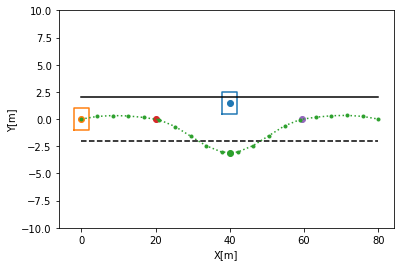

In [18]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] - pre, parked_vehicle.pos[0] + dx, parked_vehicle.pos[0] + back, line_center[0][1]], 
    [ego_vehicle.pos[1], ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, ego_vehicle.pos[1], line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline2(points[0], points[1], 20)
    
eval_val = 0 
# (１)死角
w_dead_area = 1
eval_val += w_dead_area * calculation_dead_area(path_x, path_y, pre)
# (２)はみ出し
w_out_of_road = 100
eval_val += w_out_of_road * calculation_out_of_road(path_x, path_y)
# (３)衝突
w_collision = 1
eval_val += w_collision * calculation_collision(path_x, path_y)
# (４)道路中央を走行
w_center_of_road = 1
eval_val += w_center_of_road * calculation_center_of_road(path_x, path_y)
# (５)ジャーク（yの二回微分）
w_lat_jark = 1
eval_val += w_lat_jark * calculation_lat_jark(path_x, path_y)    
# (６)ハンドル角速度（曲率変化量） 
w_steer_vel = 1
eval_val += w_steer_vel * calculation_steer_vel(path_x, path_y)

print(eval_val)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(points[0][2], points[1][2])
plt.scatter(points[0][1], points[1][1])
plt.scatter(points[0][3], points[1][3])
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [19]:
calculation_dead_area(path_x, path_y,pre)

1388.9762238469264

In [20]:
calculation_collision(path_x, path_y)

0.01462477374628023

In [21]:
calculation_center_of_road(path_x, path_y)

92.69380899621771

In [22]:
calculation_out_of_road(path_x, path_y)

8004

In [23]:
calculation_lat_jark(path_x, path_y)

4.092553194336183

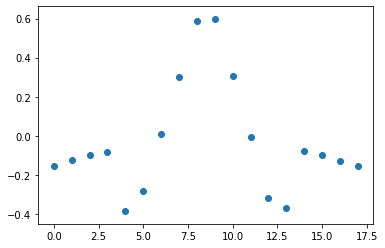

In [24]:
plt.scatter(range(len(np.diff(path_y, n=2))),np.diff(path_y, n=2))

In [25]:
calculation_steer_vel(path_x, path_y)

0.16758003843467809

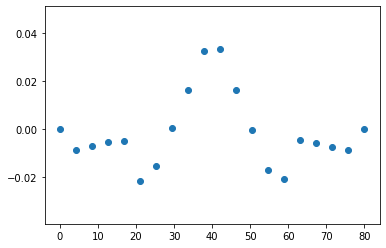

In [26]:
cv = CalcCurvature(path_x, path_y)
plt.scatter(path_x, cv)

In [27]:
def calculate_lateral_error(x, y, ori, d_preview, path_x, path_y):
    x_pp = x + d_preview * np.cos(ori)
    y_pp = y + d_preview * np.sin(ori)

    if (np.tan(ori) < 0.01):
        a = 1e10
    else:
        a = 1/np.tan(ori)
        
    b = 1
    c = -(a*x_pp+y_pp)
    d = np.abs(a*path_x + b*path_y + c) / np.sqrt(a*a + b*b)
    ind = np.argmin(d)
    
    if 0:
        plt.scatter(x, y);
        plt.scatter(path_x, path_y)
        plt.scatter(x_pp, y_pp);
        plt.plot([x,x_pp],[y,y_pp],'k:')
        plt.scatter(path_x[ind],path_y[ind])
        plt.plot([x_pp,path_x[ind]],[y_pp,path_y[ind]],'k--')
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
        
    aa = -np.tan(ori)
    bb = 1
    cc = -(aa*x_pp + b*y_pp)
    lat_error = (aa*path_x[ind] + bb*path_y[ind] + cc) / np.sqrt(aa*aa + bb*bb)
    
    return lat_error*0.1

In [28]:
import matplotlib.animation as anm
from matplotlib.animation import PillowWriter

In [29]:
def run_simulation(i):
#    while(ego_vehicle.pos[0]<road_length):
    # 減速度の計算
    k = 0.01
    G_FB = 0.1
    if (ego_vehicle.pos[0] < parked_vehicle.pos[0]) & (pre < ego_vehicle.pos[0]):
        a = -(k * (pre - ego_vehicle.pos[0])**2)/2
        print("---------- deceletion. ----------")
    else:
        a = G_FB*(ub_vel - ego_vehicle.vel)
        print("---------- keep. ----------")

    # 車速の更新
    v = ego_vehicle.vel + a * dt
    ego_vehicle.vel = v

    # 前方注視モデルによるヨーレイトの計算
    preview_d = ego_vehicle.vel*pre_t
    gamma = calculate_lateral_error(ego_vehicle.pos[0], ego_vehicle.pos[1], ego_vehicle.ori, preview_d, path_x, path_y)

    # 自車パラメータの更新
    ego_vehicle.ori = ego_vehicle.ori + gamma * dt
    ego_vehicle.pos[0] = ego_vehicle.pos[0] + np.cos(ego_vehicle.ori) * ego_vehicle.vel * dt
    ego_vehicle.pos[1] = ego_vehicle.pos[1] + np.sin(ego_vehicle.ori) * ego_vehicle.vel * dt

    # 表示
    print("a : ", a)
    print("vel : ", ego_vehicle.vel * 3.6)
    print("ori : ", ego_vehicle.ori*180/np.pi)
    print("preview dist : ", preview_d)

    # ログ
    path_ego_x.append(ego_vehicle.pos[0])
    path_ego_y.append(ego_vehicle.pos[1])
    yawrate.append(gamma)
    velocity.append(ego_vehicle.vel)

    # 表示
    ax.clear()
    ax.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
    vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori, ax)
    ax.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
    vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori, ax )
    ax.quiver(ego_vehicle.pos[0], ego_vehicle.pos[1], np.cos(ego_vehicle.ori)*preview_d, np.sin(ego_vehicle.ori)*preview_d,
              angles='xy', scale_units='xy', scale=1)
    ax.quiver(ego_vehicle.pos[0], ego_vehicle.pos[1], np.cos(ego_vehicle.ori)*a, np.sin(ego_vehicle.ori)*a,
              angles='xy', scale_units='xy', scale=1, color='r')

    ax.plot(line_left[0], line_left[1], 'k')
    ax.plot(line_right[0], line_right[1], '--k')

    ax.scatter(points[0],points[1])
    ax.plot(path_x, path_y,':')

    ax.set_xlim([ego_vehicle.pos[0]-10,ego_vehicle.pos[0]+10])
    ax.set_ylim([ego_vehicle.pos[1]-10,ego_vehicle.pos[1]+10])    
    ax.set_xlabel('X[m]')
    ax.set_ylabel('Y[m]')

---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.18749746504645148
preview dist :  8.333333333333334


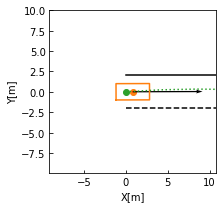

In [30]:
ego_vehicle.pos = [0,0]
ego_vehicle.size = [4,2]
ego_vehicle.ori = 0
ego_vehicle.vel = 30 / 3.6

ub_vel = 30 / 3.6
pre_t = 1.0
dt = 0.1

path_ego_x = []
path_ego_y = []
yawrate = []
velocity = []

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
run_simulation(0)
ax.tick_params(direction='in')

In [31]:
frames = list(range(100))
ani = anm.FuncAnimation(fig, run_simulation, frames=frames)

In [32]:
ani.save('test.gif', writer='pillow', fps=10)

---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.35920469411296685
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.5178807476921997
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.6206869360259842
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.7130749250232709
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.7968701216337223
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.8735698255668725
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.9444138788743506
preview dist :  8.333333333333334
---------- keep. ----------
a :  0.0
vel :  30.000000000000004
ori :  0.8918916526627536
preview dist :  8.333333333333334
---------- keep

---------- keep. ----------
a :  0.15622018717098288
vel :  24.432312529226174
ori :  6.783677197887675
preview dist :  6.786753480340604
---------- keep. ----------
a :  0.15465798529927302
vel :  24.487989403933913
ori :  7.649999834320325
preview dist :  6.802219278870531
---------- keep. ----------
a :  0.1531114054462803
vel :  24.543109509894574
ori :  8.469240383595045
preview dist :  6.817530419415159
---------- keep. ----------
a :  0.1515802913918175
vel :  24.59767841479563
ori :  9.224931798535572
preview dist :  6.832688448554341
---------- keep. ----------
a :  0.15006448847789927
vel :  24.651701630647672
ori :  9.917426551274133
preview dist :  6.847694897402131
---------- keep. ----------
a :  0.1485638435931203
vel :  24.705184614341196
ori :  10.556635070233144
preview dist :  6.862551281761443
---------- keep. ----------
a :  0.14707820515718906
vel :  24.758132768197786
ori :  11.150951599766044
preview dist :  6.877259102277162
---------- keep. ----------
a :  0.1

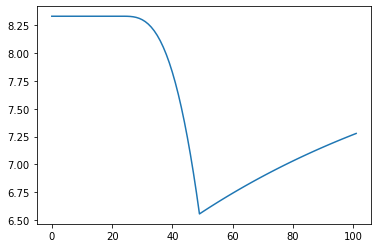

In [34]:
plt.plot(range(len(velocity)), velocity)

### やり残したこと
・対向車/後続車あり

・縦列駐車

・両サイドに駐車車両